In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kwant
import scipy.sparse.linalg as sla
import scipy.sparse as sp
from scipy.constants import hbar, e, m_e, h
from types import SimpleNamespace
import tinyarray
import time
import sys
import os

# Simulating graphene quantum dots

I will start by making graphene quantum dots with different shapes. The most interesting shapes for our sake are:

1. **Circular**
2. **Hexagonal**
3. **Triangular**
4. **Nanoribbons**

Nanoribbons do not really classify as quantum dots, but they have nice topological properties that could be useful.

The functions `create_graphene_hexagonal_system`, `create_graphene_tiangular_system` and `create_graphene_circular_system` will create graphene quantum dots of the specified shapes, the first two functions have a `start` parameter which is a starting angle and `type_` which specifies the edge types (zigzag or armchair), with the default being armchair. `param` parameter is an object where the miscellaneous parameters of the model are stored, such as (nnn) interaction coefficient `t_prime` and the magnetic field strength (normalized with the flux quanta $\hbar/e$) `B`.

In [85]:
def atan(y, x):
    ans = np.arctan2(y, x)
    if type ( x + 0.0) == type(y+0.0) and type(x+0.0) in [float, np.float64, np.float128, np.float_]:

        if ans < 0: return 2*np.pi + ans
        else: return ans

    elif type(x) == type(y) and type(x) == type(np.array([])) :
        ans[ans < 0] += 2*np.pi
        return ans

    else: raise TypeError("atan is getting neither floats nor arrays")

# define graphene lattices
def create_graphene_hexagonal_system(r, start = 0, a = 1.0, norb = 1, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices

    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 6, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            else: y += 1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside
    
    def onstie(site, param):
        x, y = site.pos
        return 0.0
    
    def nn_hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))
    
    def nnn_hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return 1j*param.t_prime*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))
    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = onstie # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = nn_hopping

    # Choose a specific site

    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    # make sure that no lattice point is connected to more than one site
    for s in sites:
        num_connections = sum(1 for _ in sys.neighbors(s))
        if num_connections == 1: del sys[s]

    sys[lat.neighbors(n=2)] = nnn_hopping

    return sys

def create_graphene_tiangular_system(r, start = 0, a = 1.0, norb = 1, type_ = 'zigzag'):
    lat = kwant.lattice.honeycomb(a = a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    # returns a boolean function which tests whether the vector is inside the regular polygon
    def Regular_Polygon(r, n = 3, start = 0):
        if n < 3: raise RuntimeError("n >= 3")
        # start specifies the first radius starting angle
        def is_inside(point):
            x, y = point
            # y-=1
            if type_ == 'zigzag':y -=1
            angle = atan(y, x) - start
            angle %= (2*np.pi/n)
            alpha = (n - 2)/2/n*np.pi
            return np.sqrt(x*x + y*y) < np.sin(alpha)/np.sin(alpha + angle)*r
        return is_inside
    def onstie(site, param):
        x, y = site.pos
        return 0.0
    
    def nn_hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))
    
    def nnn_hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return 1j*param.t_prime*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))
    # create system
    sys = kwant.Builder()
    sys[lat.shape(Regular_Polygon(r, start=start), (0, 0))] = onstie # onsite energies are set to 0
    sys[lat.neighbors(n=1)] = nn_hopping

    # Choose a specific site
    sites = list(sys.sites())
    # Count the number of connections (hopping terms) for the site
    # make sure that no lattice point is connected to more than one site
    for __ in range(2):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]
    
    sys[lat.neighbors(n=2)] = nnn_hopping
    
    return sys

def create_graphene_circular_system(r, a=1.0, norb=1):
    lat = kwant.lattice.honeycomb(a=a, norbs=norb)
    a_lat, b_lat = lat.sublattices
    
    def onstie(site, param):
        x, y = site.pos
        return 0.0
    def nn_hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))
    def nnn_hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return 1j*param.t_prime*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))
    
    sys = kwant.Builder()
    sys[lat.shape(lambda pos: np.linalg.norm(np.array([*pos])) < r, (0, 0))] = onstie
    sys[lat.neighbors(n=1)] = nn_hopping

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    sys[lat.neighbors(n=2)] = nnn_hopping

    return sys

def create_graphene_nanoribbon(width, length, a=1.0, norb=1):
    lat = kwant.lattice.honeycomb(a=a, norbs=norb)
    a_lat, b_lat = lat.sublattices

    def onstie(site, param):
        x, y = site.pos
        return 0.0
    def nn_hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))
    def nnn_hopping(site1, site2, param):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return 1j*param.t_prime*np.exp(-1j*param.B/2*(x2 - x1)*(y1 + y2))

    sys = kwant.Builder()
    sys[lat.shape(lambda pos: abs(pos[1]) < width and abs(pos[0])<length, (0, 0))] = onstie
    sys[lat.neighbors(n=1)] = nn_hopping

    for __ in range(3):
        sites = list(sys.sites())
        for s in sites:
            num_connections = sum(1 for _ in sys.neighbors(s))
            if num_connections == 1 or num_connections == 0: del sys[s]

    sys[lat.neighbors(n=2)] = nnn_hopping
    # attach leads
    sym = kwant.TranslationalSymmetry((-a, 0))
    lead = kwant.Builder(sym)
    lead[lat.shape(lambda pos: abs(pos[1]) < width, (0, 0))] = onstie
    lead[lat.neighbors(n=1)] = nn_hopping
    lead[lat.neighbors(n=2)] = nnn_hopping
    sys.attach_lead(lead)
    sys.attach_lead(lead.reversed())
    return sys

The Hamiltonian class is meant to ease dealing with the hamiltonians, getting eigenvalues, and plotting them, `.sol()` should be called to get the eigenvalues and/or vectors

In [86]:
class Hamiltonian:
    def __init__(self, h, N=None):
        self.h = h
        if N is None: self.N = h.shape[0]
        else: self.N = N
        self.sol = None
        self.energies = None
        self.eigenstates = None
    
    def solve(self, k=None, return_eigenvectors=True):
        if k is None: k = self.N-2
        self._returned_eigenvectors = return_eigenvectors
        if return_eigenvectors is False:
            self.sol =  [sla.eigsh(self.h, k=k, which='SM', return_eigenvectors=return_eigenvectors)]
        else:
            self.sol =  sla.eigsh(self.h, k=k, which='SM', return_eigenvectors=return_eigenvectors)
    
    def get_eigenvalues(self):
        if self.sol is None: self.solve(return_eigenvectors=False)
        self.eigenenergies = np.sort(self.sol[0])
        return self.eigenenergies
    
    def get_eigenstates(self):
        if self._returned_eigenvectors is False: self.solve(return_eigenvectors=True)
        self.eigenstates = (self.sol[1].T)[np.argsort(self.sol[0])]
        return self.eigenstates
    
    def get_eigenstate(self, i):
        if self.eigenstates is None: self.get_eigenstates()
        return self.eigenstates[i]
    
    def zero_energy(self):
        if self.eigenenergies is None: self.get_eigenvalues()
        return np.where(np.abs(self.eigenenergies) < 1e-6)[0]
    
    def plot_state(self, system, i):
        if self.eigenstates is None: self.get_eigenstates()
        kwant.plotter.map(sys=system, value=self.eigenstates[i], oversampling=10, cmap='inferno', show=True, dpi=400)
        plt.show()


## Triangular Isolated dots

In [92]:
triangular_predot = create_graphene_tiangular_system(10, np.pi/2, 1.0, 1, 'zigzag')

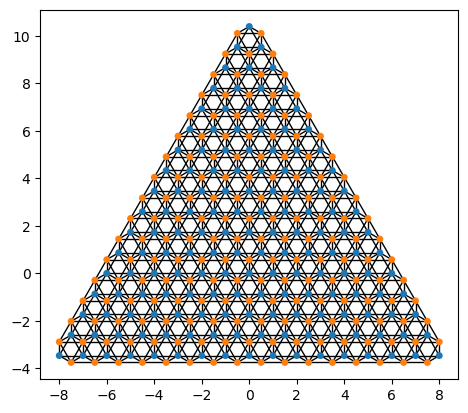

In [93]:
kwant.plot(triangular_predot)
plt.show()

In [182]:
triangular_dot = triangular_predot.finalized()
h = triangular_dot.hamiltonian_submatrix(params=dict(param = SimpleNamespace(B=0.0, t_prime=0.05)), sparse=True)
N = h.shape[0]

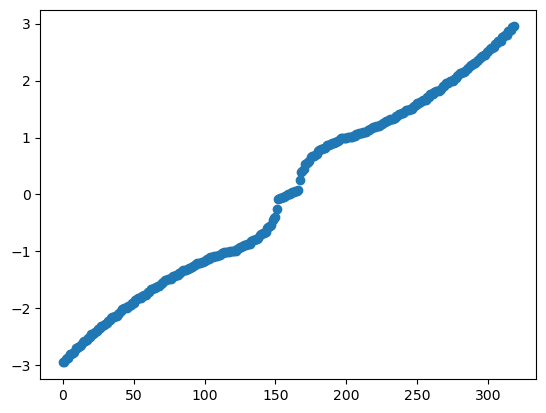

In [184]:
hamiltonian = Hamiltonian(h, N)
hamiltonian.solve(return_eigenvectors=True)
energies = hamiltonian.get_eigenvalues()
plt.scatter(range(N-2), energies)
plt.show()

In [185]:
hamiltonian.zero_energy()

array([159])

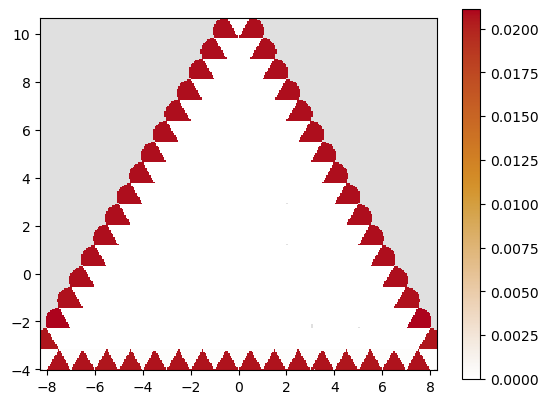

In [186]:
state = np.zeros_like(hamiltonian.get_eigenstate(44))
for ind in hamiltonian.zero_energy():
    state += hamiltonian.get_eigenstate(ind)
if not np.allclose(state, 0): state /=np.sqrt(len(hamiltonian.zero_energy()))
if np.allclose(state, 0): state = hamiltonian.get_eigenstate(160)
kwant.plotter.map(triangular_dot, np.abs(state)**2, oversampling=10)
plt.show()

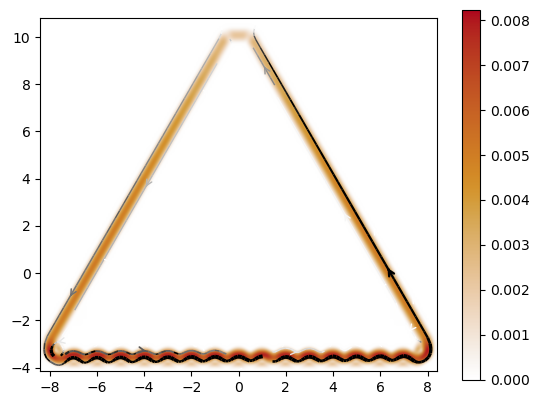

array([ 4.14848312e-03, -3.90097911e-03,  1.61460304e-05, ...,
        5.22262206e-06, -2.02022725e-03, -1.95314514e-03])

In [187]:
# calculate the current
def calculate_current(sys, state, param, plot=False):
    current = kwant.operator.Current(sys)
    i = current(state, params=dict(param=param))
    if plot:
        kwant.plotter.current(sys, i)
        plt.show()
    return i

calculate_current(triangular_dot, state, SimpleNamespace(B=0.2, t_prime=0.05), plot=True)

## Nanoribbons

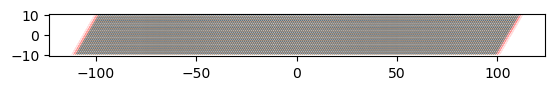

In [ ]:
# create a nanoribbon
ribbon = create_graphene_nanoribbon(10, 100, 1.0, 1)
kwant.plot(ribbon)
plt.show()

In [88]:
ribbon = ribbon.finalized()

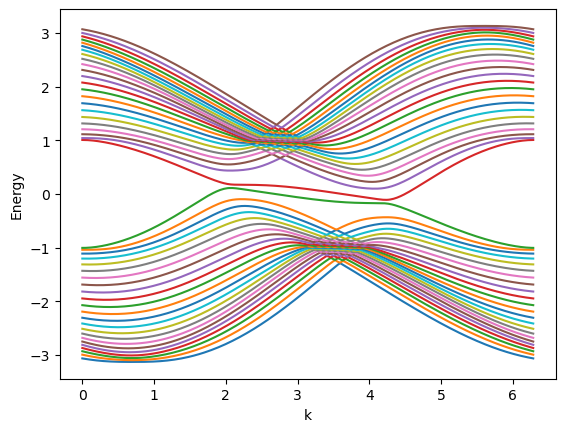

In [ ]:
kwant.plotter.bands(ribbon.leads[0], params=dict(param=SimpleNamespace(B=0.0, t_prime=0.1)), show=True, momenta=np.linspace(0, 2*np.pi, 256))
plt.show()

In [201]:
ribbon_parameters = SimpleNamespace(B=0.05, t_prime=0.0)
state_rib = kwant.wave_function(ribbon, energy=0.1, params=dict(param=ribbon_parameters))
state_rib = state_rib(0)
state_rib

array([[-0.00040449-2.04289183e-05j,  0.00057355-6.94990887e-04j,
         0.00037737+1.53314082e-03j, ..., -0.01883196-2.04853979e-01j,
         0.12180291+7.43139230e-02j, -0.06797762+2.74254936e-02j]])

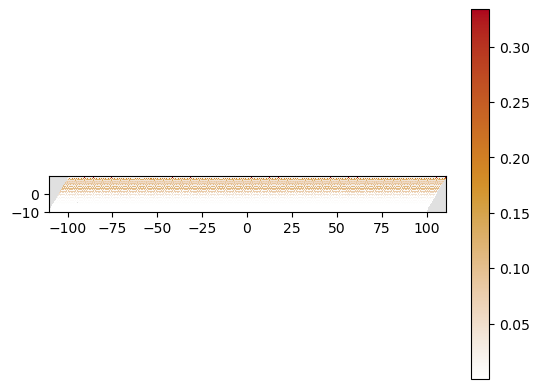

In [202]:
kwant.plotter.map(ribbon, np.abs(state_rib[0])**2, oversampling=10)
plt.show()
density_rib_op = kwant.operator.Density(ribbon)
current_rib_op = kwant.operator.Current(ribbon)


density_rib = density_rib_op(state_rib[0])
current_rib = current_rib_op(state_rib[0], params=dict(param=ribbon_parameters))

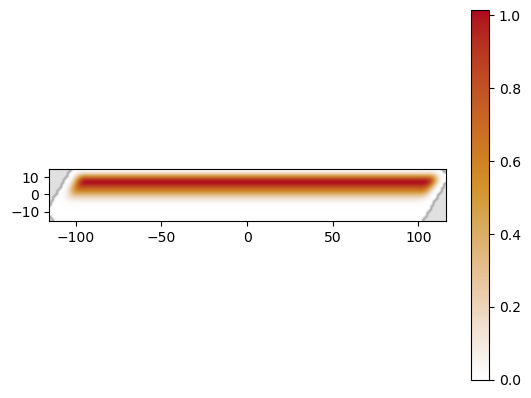

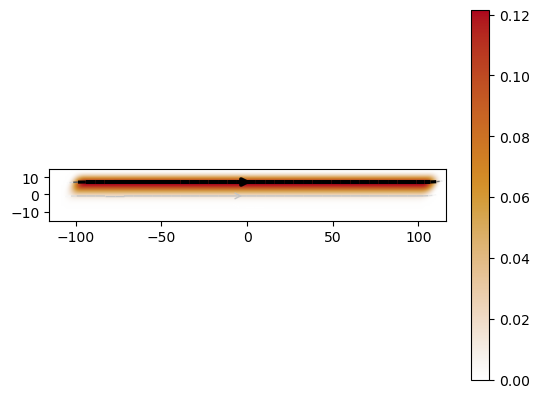

In [203]:
kwant.plotter.density(ribbon, density_rib)
plt.show()
kwant.plotter.current(ribbon, current_rib)
plt.show()

In [153]:
state_rib(0)

array([[-0.00046235-1.64348693e-04j,  0.00066896-8.68681116e-04j,
         0.00110599+1.61709314e-03j, ...,  0.00069893+1.83021908e-03j,
        -0.00109503+5.48983407e-05j,  0.00012833-4.73614529e-04j]])

In [79]:
kwant.wave_function(ribbon, energy=1e-19, params=dict(param=SimpleNamespace(B=0.02, t_prime=0.05)))(0)

array([], shape=(0, 9175), dtype=float64)